<a href="https://colab.research.google.com/github/SUYAMBULAKSHMI-VENKATESAN/DAMAKA/blob/main/Iris_Mask.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
import os
drive.mount('/content/drive')



Mounted at /content/drive


In [ ]:
import os
import cv2
import torch
import torchvision
import numpy as np
from PIL import Image
from glob import glob
from tqdm import tqdm
from torchvision.transforms import functional as F

# Paths
input_folder = "/content/drive/MyDrive/Pre_Image"
output_folder = "/content/drive/MyDrive/IrisMasks_RingOnly_final"
os.makedirs(output_folder, exist_ok=True)

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load Mask R-CNN pretrained model
model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)
model.eval().to(device)

# Step 1: Enhance image with Gaussian + CLAHE + HE
def enhance_image(path):
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)

    # Gaussian blur
    blur = cv2.GaussianBlur(img, (5, 5), 1.0)

    # CLAHE
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    clahe_img = clahe.apply(blur)

    # Histogram Equalization
    he_img = cv2.equalizeHist(clahe_img)

    # Convert to RGB for Mask R-CNN
    rgb_img = cv2.cvtColor(he_img, cv2.COLOR_GRAY2RGB)
    return Image.fromarray(rgb_img)

# Step 2: Run Mask R-CNN and return mask
def predict_mask(img_tensor, threshold=0.3):
    with torch.no_grad():
        prediction = model([img_tensor.to(device)])[0]

    masks = prediction['masks']
    scores = prediction['scores']

    if len(masks) == 0:
        return None

    final_mask = torch.zeros_like(masks[0][0], dtype=torch.uint8)
    for i, score in enumerate(scores):
        if score > threshold:
            mask = masks[i][0] > 0.5
            final_mask = torch.bitwise_or(final_mask, mask.byte())

    return final_mask.cpu().numpy()

# Step 3: Iris Ring Extraction — removes central pupil
def extract_iris_ring(mask):
    contours, _ = cv2.findContours(mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        return mask

    # Get largest blob (iris + pupil)
    largest = max(contours, key=cv2.contourArea)

    # Fit ellipse to it
    if len(largest) < 5:
        return mask  # can't fit ellipse
    ellipse = cv2.fitEllipse(largest)

    # Draw filled ellipse (outer iris)
    iris_mask = np.zeros_like(mask, dtype=np.uint8)
    cv2.ellipse(iris_mask, ellipse, 255, thickness=-1)

    # Draw smaller black circle to remove pupil
    (cx, cy), (MA, ma), angle = ellipse
    r_pupil = int(min(MA, ma) * 0.25)
    cv2.circle(iris_mask, (int(cx), int(cy)), r_pupil, 0, -1)

    return iris_mask

# Step 4: Loop through images and save refined iris masks
image_paths = sorted(glob(os.path.join(input_folder, "*.bmp")))

for path in tqdm(image_paths, desc="Generating Iris-Only Masks"):
    img = enhance_image(path)
    img_tensor = F.to_tensor(img).to(device)

    raw_mask = predict_mask(img_tensor)
    if raw_mask is None:
        continue

    ring_mask = extract_iris_ring(raw_mask)

    filename = os.path.splitext(os.path.basename(path))[0] + "_iris.png"
    out_path = os.path.join(output_folder, filename)
    cv2.imwrite(out_path, ring_mask)


Generating Iris-Only Masks: 100%|██████████| 2251/2251 [05:32<00:00,  6.77it/s]


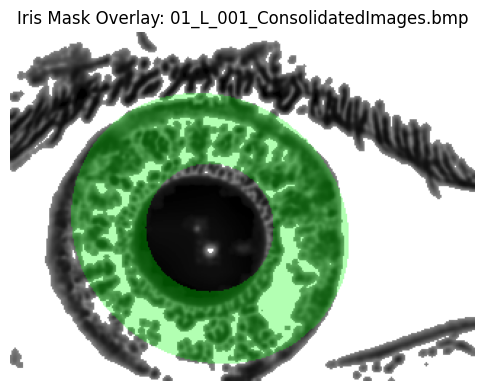

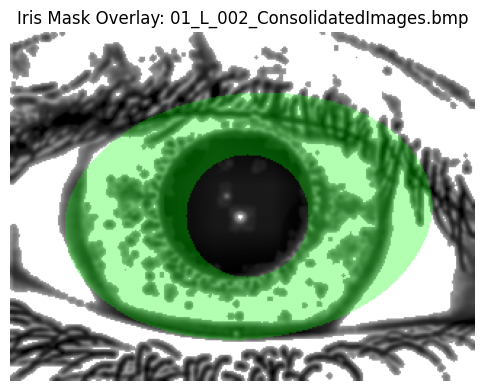

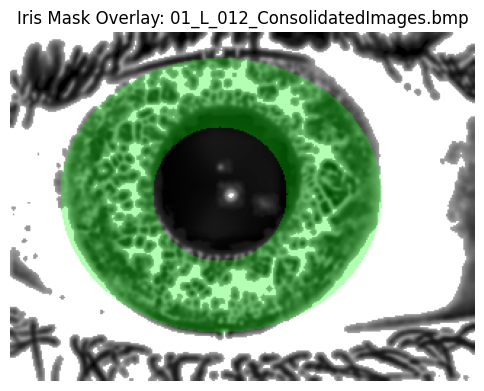

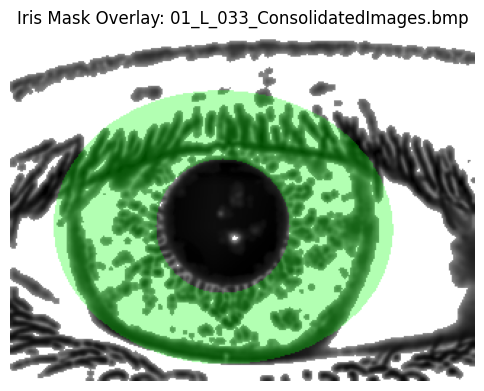

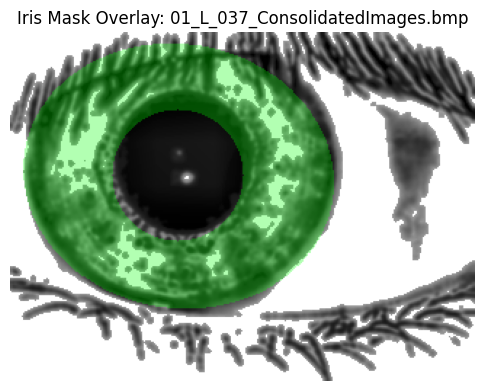

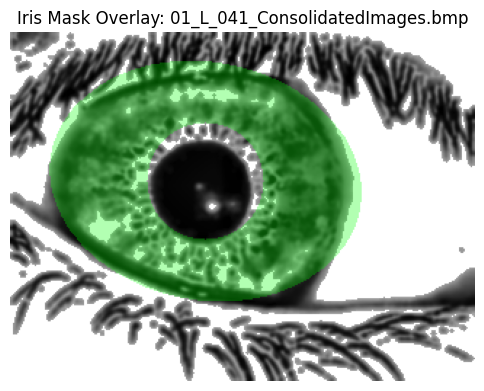

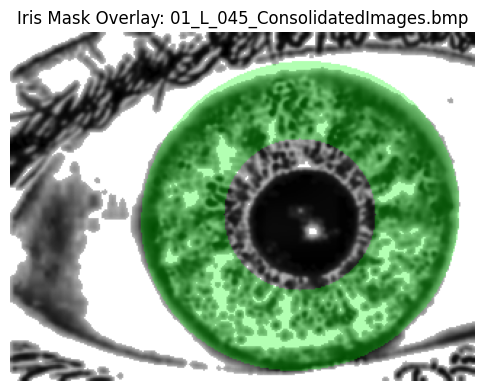

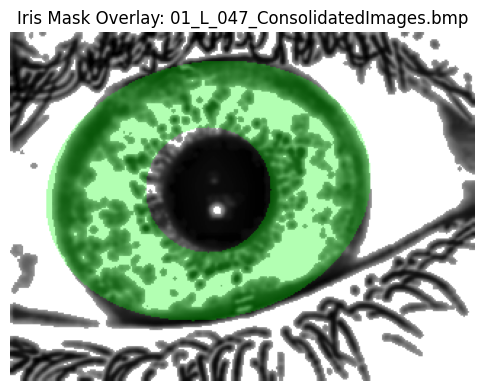

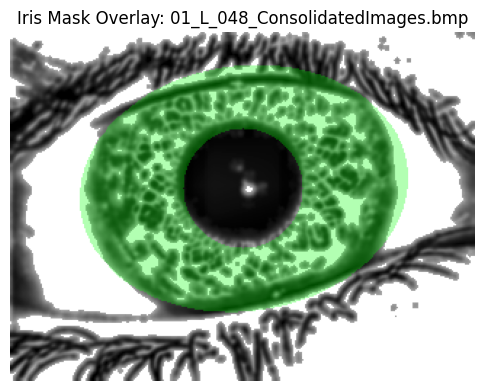

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from glob import glob
from tqdm import tqdm
from torchvision.transforms import functional as F
import torch
import torchvision

# Set paths
input_folder = "/content/drive/MyDrive/Pre_Image"
output_folder = "/content/drive/MyDrive/IrisMasks_RingOnly_final"
os.makedirs(output_folder, exist_ok=True)

# List of image base names to visualize
target_names = [
    "01_L_001_ConsolidatedImages", "01_L_002_ConsolidatedImages", "01_L_012_ConsolidatedImages", "01_L_033_ConsolidatedImages", "01_L_037_ConsolidatedImages",
    "01_L_041_ConsolidatedImages", "01_L_045_ConsolidatedImages", "01_L_047_ConsolidatedImages", "01_L_048_ConsolidatedImages"
]

# Gather all BMP image paths
image_paths = sorted(glob(os.path.join(input_folder, "*.bmp")))

# Load pretrained Mask R-CNN
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True).to(device)
model.eval()

# Step 1: Enhance the image
def enhance_image(path):
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    blur = cv2.GaussianBlur(img, (5, 5), 1.0)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    clahe_img = clahe.apply(blur)
    he_img = cv2.equalizeHist(clahe_img)
    rgb_img = cv2.cvtColor(he_img, cv2.COLOR_GRAY2RGB)
    return Image.fromarray(rgb_img)

# Step 2: Predict mask using Mask R-CNN
def predict_mask(img_tensor, threshold=0.3):
    with torch.no_grad():
        prediction = model([img_tensor.to(device)])[0]
    masks = prediction['masks']
    scores = prediction['scores']
    if len(masks) == 0:
        return None
    final_mask = torch.zeros_like(masks[0][0], dtype=torch.uint8)
    for i, score in enumerate(scores):
        if score > threshold:
            mask = masks[i][0] > 0.5
            final_mask = torch.bitwise_or(final_mask, mask.byte())
    return final_mask.cpu().numpy()

# Step 3: Remove central pupil, extract only iris ring
def extract_iris_ring(mask):
    contours, _ = cv2.findContours(mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        return mask
    largest = max(contours, key=cv2.contourArea)
    if len(largest) < 5:
        return mask
    ellipse = cv2.fitEllipse(largest)
    iris_mask = np.zeros_like(mask, dtype=np.uint8)
    cv2.ellipse(iris_mask, ellipse, 255, thickness=-1)
    (cx, cy), (MA, ma), angle = ellipse
    r_pupil = int(min(MA, ma) * 0.25)
    cv2.circle(iris_mask, (int(cx), int(cy)), r_pupil, 0, -1)
    return iris_mask

# Step 4: Visualize overlays only for selected images
for path in image_paths:
    base_name = os.path.splitext(os.path.basename(path))[0]
    if base_name not in target_names:
        continue

    img = enhance_image(path)
    img_tensor = F.to_tensor(img).to(device)

    raw_mask = predict_mask(img_tensor)
    if raw_mask is None:
        continue

    ring_mask = extract_iris_ring(raw_mask)
    img_np = np.array(img)

    overlay = img_np.copy()
    overlay[ring_mask > 0] = [0, 255, 0]  # green overlay
    blended = cv2.addWeighted(img_np, 0.7, overlay, 0.3, 0)

    plt.figure(figsize=(6, 6))
    plt.imshow(blended)
    plt.title(f"Iris Mask Overlay: {os.path.basename(path)}")
    plt.axis('off')
    plt.show()
